# 9-7. 프로젝트: 인물 모드 문제점 찾기


### 사전준비

- Import

In [22]:
import os
import urllib   # urllib: URL 작업

import cv2
import pixellib
from pixellib.semantic import semantic_segmentation  # pixellib: 이미지 및 비디오 segmentation

from PIL import Image
import cv2      # cv2: OpenCV 라이브러리 - 실시간 컴퓨터 비전

from matplotlib import pyplot as plt
from importlib.metadata import version
import numpy as np

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


- 모델준비

In [23]:
# 모델은 저장했다고 가정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# semantic segmentation을 수행하는 클래스 인스턴스
model = semantic_segmentation() 

# pascal voc에 대해 훈련된 예외 모델(model_file) 로드
model.load_pascalvoc_model(model_file)

- 라벨 준비

In [24]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 컬러맵 만들기

In [69]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]                #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

## Step 1. 인물모드 직접 해 보기


### (1) 인물 이미지

- 이미지 불러오기

(1080, 1440, 3)


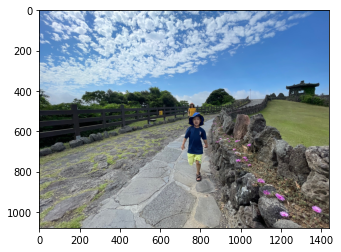

In [28]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jeju.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

 - 이미지 분할

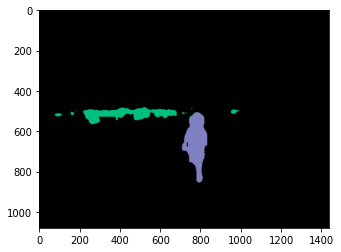

In [29]:
# segmentAsPascalvoc()함수를 호출 하여 입력된 이미지를 분할 

segvalues, output = model.segmentAsPascalvoc(img_path) 

#matplotlib을 이용해 output출력

plt.imshow(output)
plt.show()

- 이미지 라벨 출력/ 사람 colormap 찾기

In [77]:
#segvalues에 있는 class_ids가 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
# person 있다면 colormap 출력

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id], class_id)
    if LABEL_NAMES[class_id] == 'person':
        seg_colormap = colormap[class_id] 
        
print('person colormpap = ',seg_colormap)

background 0
person 15
train 19
person colormpap =  [192 128 128]


In [79]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 배치되기 때문
seg_color = (seg_colormap[2],seg_colormap[1],seg_colormap[0])
seg_color

(128, 128, 192)

(1080, 1440)


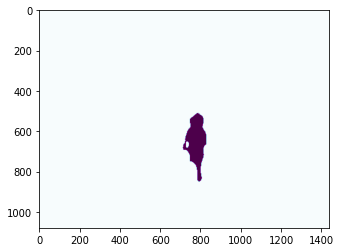

In [80]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
# seg_color 값이 person 이므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='BuPu')
plt.show()

- color mask 

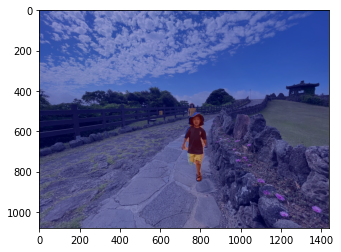

In [59]:
# color_mask : 사람이 있는 위치와 배경을 분리해서 표현한 이미지

# 원본이미지를 img_show에 할당
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기 ; cv2.addWeighted()

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)  # 0.6과 0.4는 두 이미지를 섞는 비율.

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- Blur

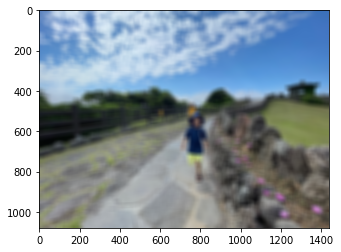

In [50]:
# blur ; 이미지 흐리기

img_orig_blur = cv2.blur(img_orig, (30,30))   # (13,13); blurring kernel size, 바꿔보기

# blur 이미지 출력
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 사람 이미지 누끼

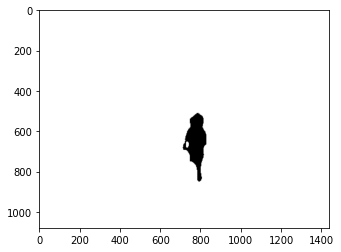

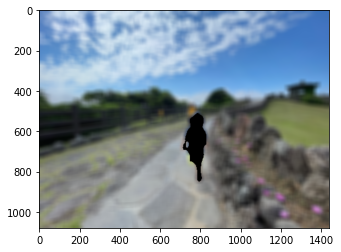

In [56]:
# 마스크 채널 변경
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 이미지가 반전 ; cv2.bitwise_not(): 
img_bg_mask = cv2.bitwise_not(img_mask_color)  # 연산을 하고 나면 배경은 255 사람은 0.

# 배경만 있는 이미지 ; cv2.bitwise_and()
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람은 모든 픽셀이 0 : 배경만 남기기

# 출력
plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB)) # 사람 마스크 반전
plt.show()

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # 배경만 남기기
plt.show()

- 결과

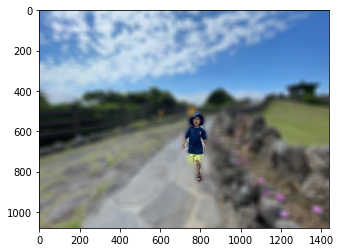

In [57]:
# 이미지 합치기 ; np.where()
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 마스크가 255면 원본, 아니면 블러 배경

# 이미지 출력
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 함수화

In [122]:
# 함수로 만들기

def bg_blur(img_file,              # 변경하려는 이미지
            seg_target,             # 중심 개체 seg. ; 나머지는 배경
            blur = 30,              # blur 정도 ; 기본 30
            bg_img = ''
            ):

#     - 이미지 불러오기
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+img_file
    img_orig = cv2.imread(img_path) 
    
#     - 배경 이미지 불러오기
    if bg_img != '':
        bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+bg_img
        bg_orig = cv2.imread(bg_path)
        
        # 배경이미지 resize
        img_size = (img_orig.shape[1],img_orig.shape[0])
        bg_orig = cv2.resize(bg_orig, img_size)

#     print(img_orig.shape)

    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

#     - 이미지 분할

    # segmentAsPascalvoc()함수를 호출 하여 입력된 이미지를 분할 

    segvalues, output = model.segmentAsPascalvoc(img_path) 

    #matplotlib을 이용해 output출력

#     plt.imshow(output)
#     plt.show()

#     - 이미지 라벨 출력/ 목표 colormap 찾기

    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id], class_id)
        if LABEL_NAMES[class_id] == seg_target:
            seg_colormap = colormap[class_id] 

    # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 배치됨.

    seg_color = (seg_colormap[2],seg_colormap[1],seg_colormap[0])

    # segment_map ; 중심 개체를 표시한 맵
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
    # seg_color 값이 person 이므로 사람이 있는 위치를 제외하고는 gray로 출력

    seg_map = np.all(output==seg_color, axis=-1) 

    #     print(seg_map.shape) 
#     plt.imshow(seg_map, cmap='BuPu')
#     plt.show()

#     - color mask 

    # color_mask : 사람이 있는 위치와 배경을 분리해서 표현한 이미지

    # 원본이미지를 img_show에 할당
    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꾸기
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꾸기
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스크 합치기 ; cv2.addWeighted()

    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)  # 0.6과 0.4는 두 이미지를 섞는 비율.

#     plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
#     plt.show()

#     - Blur

    # blur ; 이미지 흐리기

    img_orig_blur = cv2.blur(img_orig, (blur,blur))   # (13,13); blurring kernel size, 바꿔보기

    # blur 이미지 출력
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.show()

#     - 사람 이미지 누끼

    # 마스크 채널 변경
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # 이미지 반전 ; cv2.bitwise_not(): 
    img_bg_mask = cv2.bitwise_not(img_mask_color)  # 연산을 하고 나면 배경은 255 사람은 0.

    # 배경만 있는 이미지 ; cv2.bitwise_and()
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람은 모든 픽셀이 0 : 배경만 남기기

    # 출력
#     plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB)) # 사람 마스크 반전
#     plt.show()

#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # 배경만 남기기
#     plt.show()

#     - 결과
    if bg_img =='':

        # 이미지 합치기 ; np.where()
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 마스크가 255면 원본, 아니면 블러 배경

        # 이미지 출력
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
    
    else:
        # 배경 이미지 합치기 ; np.where()
        img_concat = np.where(img_mask_color==255, img_orig, bg_orig) # 마스크가 255면 원본, 아니면 블러 배경

        # 이미지 출력
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()

### (1) 인물 이미지_2

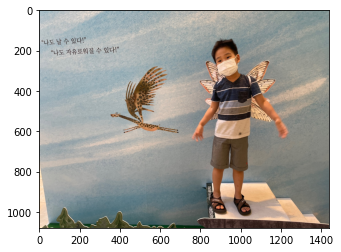

background 0
bird 3
person 15


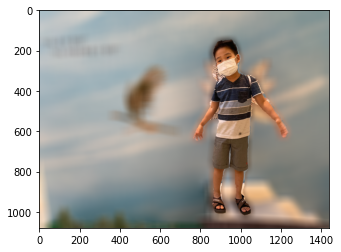

In [93]:
# 함수 확인

bg_blur('fly01.jpg','person',50)

### (2) 고양이 이미지

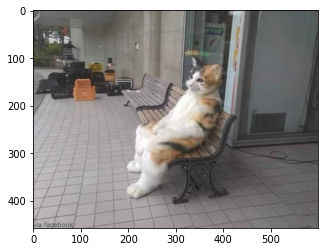

background 0
cat 8
chair 9
dog 12


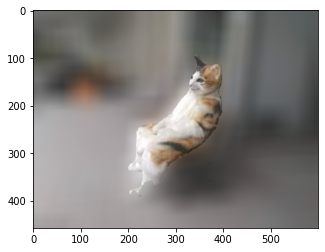

In [91]:
bg_blur('cat02.jpg','cat',50)

### (3) 배경 바꾸기

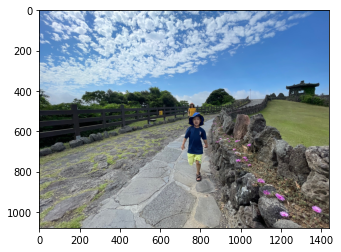

background 0
person 15
train 19


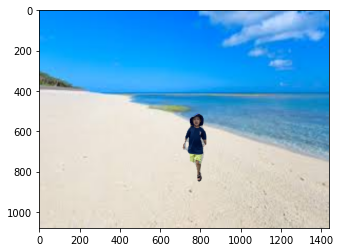

In [123]:
bg_blur('jeju.jpg','person',30, 'bg001.jpg')

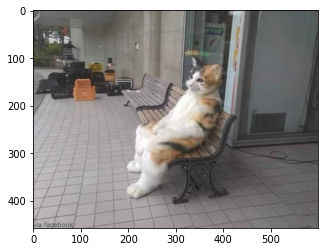

background 0
cat 8
chair 9
dog 12


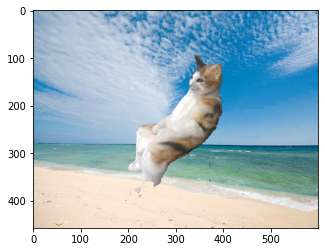

In [126]:
bg_blur('cat02.jpg','cat',30, 'bg003.jpg')

## Step 2. 사진에서 문제점 찾기



- 다음 그림에서 보는 것 처럼 귀, 엉덩이, 다리 부분에 문제가 있음.

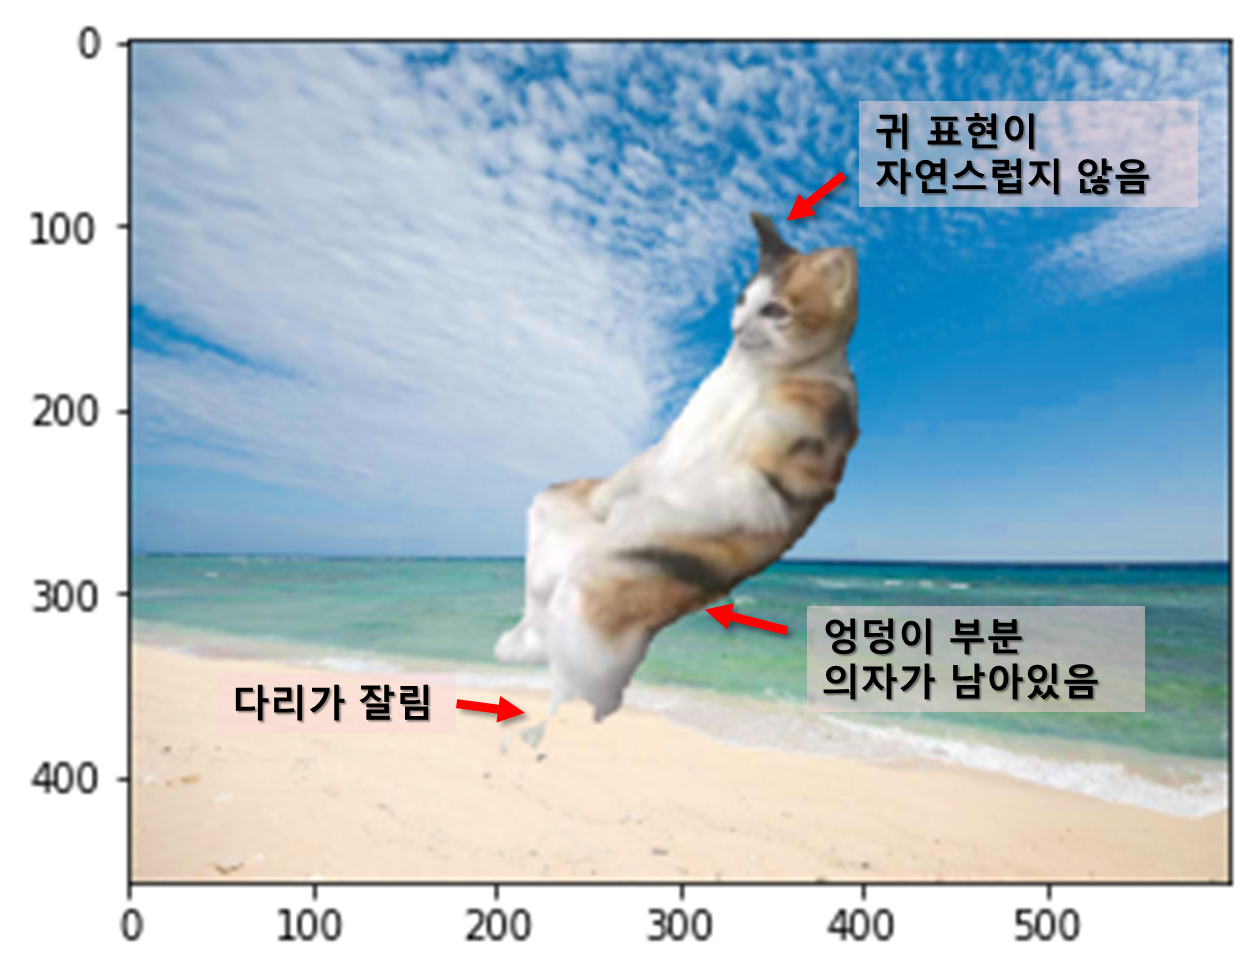

## Step 3. 해결 방법을 제안해 보기



- 피사계 심도 이해하기

피사계심도는 사진에 관련된 용어입니다.  
사진은 자연의 한 순간의 '빛'을 규격화 된 크기 안에 담는 걸 말합니다.  
즉, 사진은 정적이고 크기가 정해져 있으며 빛만 담을 수 있습니다.  
   
이런 사진 중 사람이 '보는' 방법으로 피사체를 '자연스럽게' 표현하기 위한 방법이 아웃포커싱(배경흐림, 보케)입니다.  
왜냐하면, 사람은 어떤 피사체를 볼 때, 주변은 흐리게 인식하기 때문입니다.  
  
이는 눈이 두 개이며, 뇌에서 시각 처리 과정에서 피사체를 제외한 배경에는 큰 에너지를 쓰지 않기 위해 나타나는 현상입니다.  
눈이 두 개이므로, 양안이 바라보는 중심 피사체는 뇌의 프로세싱 과정에서 합해 하나의 인식(이미지)를 만들고,  
그 보다 가깝거나 먼 배경들은 두 개의 이미지를 그대로 흐리기(블러) 때문에 바라보는 중심 피사체만 또렷하게 보입니다.  

  
이를 사진(순간의 정적이며, 정해진 크기의 이미지)으로 억지로 자연스럽게 표현하려는 방법이 아웃포커싱이며, 그 원리는 피사계 심도입니다.  
  
  
피사계 심도는 카메라 렌즈의 촛점이 맞는 범위를 나타냅니다.  
당연히도 카메라 렌즈의 중심선(렌즈의 중점과 카메라 이미지 센서(또는 필름)의 중점을 잇는 직선)에서의 거리로 표현됩니다.  
  
심도가 얕으면, 촛점이 맞는 범위가 짧고  
심도가 깊으면, 촛점이 맞는 범위가 깁니다.  

우리 눈은 심도가 얕기 때문에(중심 피사체만 또렷하게 봄) 심도가 얕은 사진이 더 자연스럽게 보입니다.  
  
배경 흐림을 효과적으로 하기 위해서는 다음 다섯가지 방법을 사용합니다.  
1. 센서 크기 키우기 : 피사체와의 거리를 가깝게 할 수 있음.
2. 배경을 멀리 두기 : 심도 밖으로 배경을 보냄.
3. 망원렌즈 사용 : 멀리 있는 피사체를 가깝게 찍을 수 있음.
4. 피사체를 가까이 : 가까운 피사체에 촛점을 맞추게 되면 주변이 더 흐려짐.
5. 렌즈의 F수를 낮게 : 더 짧은 시간에 피사체에서 나오는 빛을 받아들여, 배경의 빛은 덜 받고 흐릴 수 있음. 
  


- 해결 방법 제안  



1. 정적인 이미지

우리가 하고 싶은 것은 사람이 보는 방법으로 기계가 보길 워하는 것이라고 생각합니다.  
얕은 심도의 사진은 사실 그 결과의 하나이며, 이 외에도 사람이 보는 방식과 기계가 보는 방식의 차이가 큽니다.  
  
우선, 가장 큰 문제는 정적인 이미지입니다.  
우리 인간은 한번도 기계의 도움 없이 정적인 이미지를 '본' 적이 없습니다. 우리의 눈도 자연도 가만히 있지 않기 때문입니다.  
사진과 그림의 시작은 순간을 기록하고 싶은 인류의 욕심으로 만들어진 결과물이고, 이는 우리가 '자연스럽게' '보는' 것을 제대로 표현하지 못합니다.  
따라서 기계를 사람이 보는 방식으로 훈련하고 싶다면, CV 데이터는 정적인 이미지가 아닌 sequence를 가진 동적인 이미지여야 합니다.  
다음 링크의 결과처럼, 동적 이미지에서 그 결과를 얻는다면 좀 더 정확한 피사체의 구분이 가능할 것 같습니다.  
https://bkshin.tistory.com/entry/OpenCV-30-%EB%B0%B0%EA%B2%BD-%EC%A0%9C%EA%B1%B0Background-Subtraction  

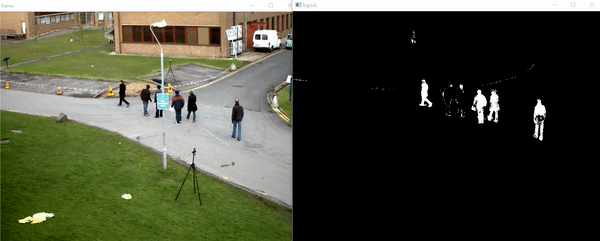

이와 관련해 우리의 문제(피사체를 제대로 구분하지 못하는)를 해결 방법으로 라이브 포토를 활용하는 것도 좋을 것 같습니다.  
라이브 포토는 짧은 시간동안 여러 장의 사진을 찍습니다. 그 순간 미세한 카메라의 흔들림으로 사진마다 피사체와 배경 사이의 간격이 생길 것이고 이를 조합하고 학습 시킨다면 피사체를 더 잘 구분할 수 있지 않을까 생각합니다.  

2, 한정된 크기와 차원  
우리는 언제든 눈과 고개, 그리고 몸을 돌려 주변을 모두 인식할 수 있습니다. 또한, 두 개의 눈을 가지고 있기 때문에 2차원의 이미지를 조합해 3차원을 인식할 수 있습니다.  
사진이나 그림 심지어 영상은 범위 밖의 정보를 담을 수 없고, 또한 2차원(채널을 제외한) 정보이기 때문에 우리가 보는 방식과 다릅니다.  
피사체를 더 잘 구분하기 위해서는 기계가 빛에 대한 정보를 3차원으로 인식해야 하고 범위 밖을 더 자유롭게 볼 수 있도록 해야 합니다.  
이는 다시 하드웨어의 한계에 직면하기 때문에 당장은 해결되지 않겠지만, 이미지 정보는 2차원이 아닌 3차원을 담을 수 있어야 할 것입니다.  

이미 우리가 가진 스마트폰은 여러개의 카메라가 일정한 간격을 두고 배열 돼 있고, insta360 같은 3d 카메라가 시중에 나와 있습니다. 이들의 정보를 얻고 처리하고 학습할 수 있다면 좀 더 인간이 보는 방식으로 사물을 인식할 수 있게 되지 않을까 생각합니다.  
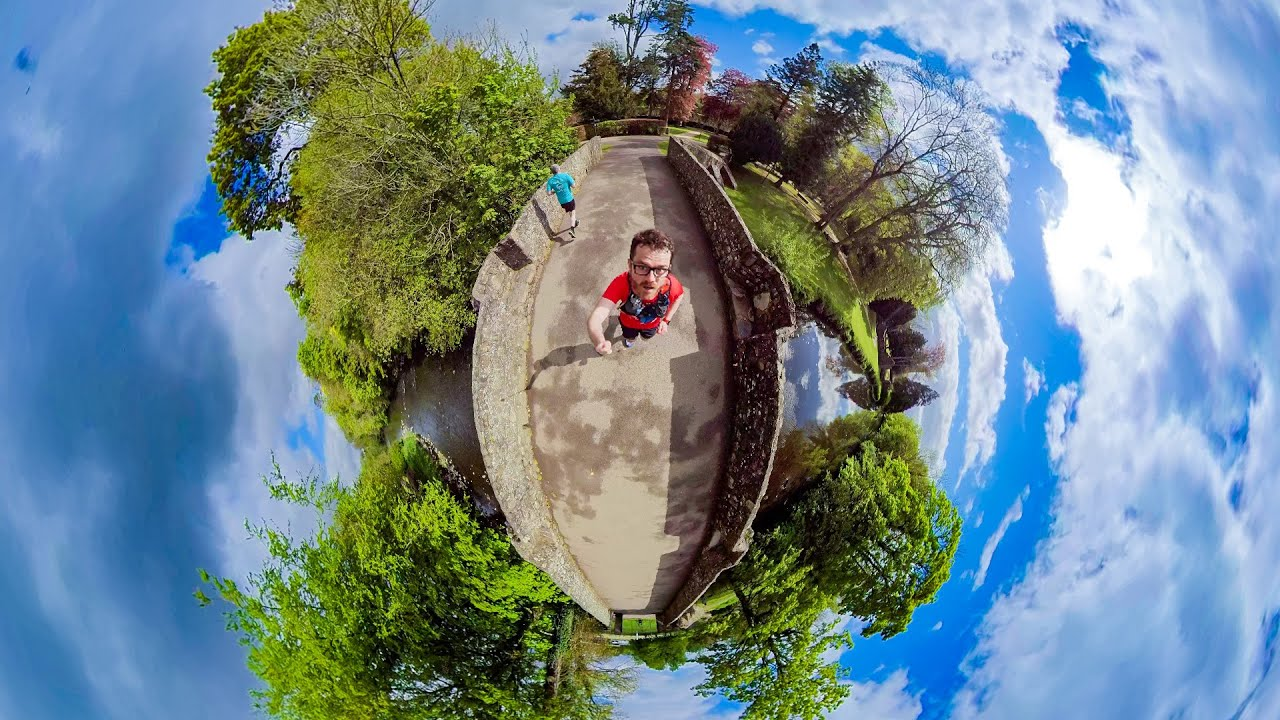
https://m.blog.naver.com/erke2000/221579180215

3. 빛 이외의 정보를 담기  
우리 인간은 사실 빛 중에서도 가시광선 영역의 일부만 '볼' 수 있습니다. 하지만, 다른 감각을 동원한다면, 더 많은 정보를 한번에 받아들입니다. 즉, 소리, 냄새, 피부의 감각 등으로 자연을 인식합니다.  
기계도 이와같은 정보를 시간에 따른 시계열 정보로 받아들인다면 인간이 자연을 인식하는 것과 비슷하게 인식할 수 있을 지 모릅니다.  
만약, 기계가 빛 중에서도 적외선, 자외선, 마이크로 웨이브 등을 인식할 수 있다면 인간이 느낄 수 없는 시각 정보를 이용해 더 많은 일을 할 수 있을 것입니다. 실제로 침입감지 시스템은 마이크로 웨이브 센서를 사용하며 이를 이용해 군사목적으로 벽 넘어 사람을 인식하는 기술이 도입되고 있습니다.  
우리의 문제에 촛점을 맞춰보면, 스마트폰의 얼굴인식 센서나 ToF 센서 등의 이용으로 가시광선 이외의 빛을 이용하면 피사체를 더 잘 구분할 수 있지 않을까 생각합니다.  



